<a href="https://colab.research.google.com/github/abhibeats95/ML-model-for-Recognition-of-Digits/blob/main/loadingdatawithID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
#imgdriveinfo = drive.ListFile({'q': "title contains 'images.pickle'"}).GetList()
#clsdriveinfo= drive.ListFile({'q': "title contains 'class.pickle'"}).GetList()
listed=drive.ListFile({'q': "title contains '.pickle'"}).GetList()


for file in listed:
   print('title {}, id {}'.format(file['title'], file['id']))

title images.pickle, id 1SRS0nw7s8RnDP4QbnWwbl88YcD4jLvfP
title classes.pickle, id 1kZVqNEEfIsWNEV_XWrB5e0z5lbf6HAvJ
title variables.pickle, id 1NRsuEVZ6I-hP8344UKzpQmR36Xoq55ik


In [14]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import pickle
from googleapiclient.http import MediaIoBaseDownload


pickle_list=[]


file_id_cls,file_id_img = '1kZVqNEEfIsWNEV_XWrB5e0z5lbf6HAvJ','1SRS0nw7s8RnDP4QbnWwbl88YcD4jLvfP'
fileid_list=[file_id_cls,file_id_img]
for id in fileid_list:
    request = drive_service.files().get_media(fileId=id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
          _, done = downloader.next_chunk()
    downloaded.seek(0)
    pickle_data = pickle.load(downloaded)
    pickle_list.append(pickle_data)

In [15]:
classes=pickle_list[0]
images=pickle_list[1]
len(images)

10160

In [16]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D



**PARAMETERS**


In [17]:
############parameters##########
test_ratio=0.2
val_ratio=0.2
img_dim=(32,32,3)
#images=[]
#classes=[]
batch_size_val=50
epochs_val=10
steps_per_epoch_val=2000
###########parameters############


**Splitting the data**

In [18]:
images=np.array(images)
classes=np.array (classes)
print(images.shape)

###splitting the data##########
x_train,x_test,y_train,y_test = train_test_split(images,classes,test_size=test_ratio)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=val_ratio)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(10160, 32, 32, 3)
(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)


In [19]:
print(len(np.where(y_train=='0')[0]))
print(len(np.where(y_test=='0')[0]))
print(len(np.where(y_val=='0')[0]))

663
205
148


**Ploating Distribution Chart of No of Images for Each Class**

[663, 626, 672, 649, 664, 631, 641, 675, 654, 627]


Text(0, 0.5, 'no_of_samples')

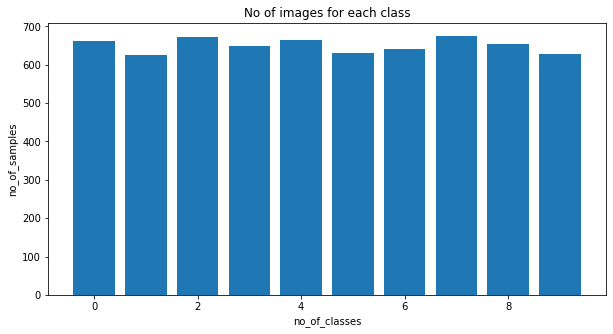

In [20]:
###plotting the barchart for the distribution of images for each classes######
no_of_samples=[]
no_of_classes=10
for x in range(0,no_of_classes):
    no_of_samples.append(len(np.where(y_train==str(x))[0]))
print(no_of_samples)

plt.figure(figsize=(10,5))
plt.bar(range(0,no_of_classes),no_of_samples)
plt.title("No of images for each class")
plt.xlabel("no_of_classes")
plt.ylabel("no_of_samples")

**Data Preprocessing**

In [21]:
#####data preprocessing #########
def preprocessing(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.equalizeHist(img)
  img=img/255
  return img

In [22]:
x_train=np.array(list(map(preprocessing,x_train)))
x_test= np.array(list(map(preprocessing,x_test)))
x_val= np.array(list(map(preprocessing,x_val)))

In [23]:
x_test.shape

(2032, 32, 32)

**Reshape the images for Training**

In [24]:
########Reshape the images###########
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_val=x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)

**Data Agumentation Process**

In [25]:
###Data Augumentation#########
dataGen=ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
dataGen.fit(x_train)

In [26]:
x_train.shape

(6502, 32, 32, 1)

In [27]:
no_of_classes

10

**ONE HOT ENCODINGS OF LABELS MATRICS**

In [28]:
##########ONE HOT ENCODINGS OF MATRIX#############
y_train=to_categorical(y_train,no_of_classes)
y_test=to_categorical(y_test,no_of_classes)
y_val=to_categorical(y_val,no_of_classes)

**CREATING MODEL**

In [29]:
##########Creating the model###########
def Model():
  no_of_filters=60
  size_of_filter1=(5,5)
  size_of_filter2=(3,3)
  size_of_pool=(2,2)
  no_of_nodes=500

  model=Sequential()
  model.add((Conv2D(no_of_filters,size_of_filter1,input_shape=(img_dim[0],img_dim[1],1),activation='relu')))
  model.add((Conv2D(no_of_filters,size_of_filter2,activation='relu')))
  model.add((MaxPooling2D(pool_size=size_of_pool)))
  model.add((Conv2D(no_of_filters//2,size_of_filter2,activation='relu')))
  model.add((Conv2D(no_of_filters//2,size_of_filter2,activation='relu')))
  model.add((MaxPooling2D(pool_size=size_of_pool)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(no_of_nodes,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(no_of_classes,activation='softmax'))

  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model


In [30]:
model=Model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 60)        32460     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [31]:
y_train.shape

(6502, 10)

**Starting with Training**

In [32]:
history = model.fit_generator(dataGen.flow(x_train,y_train,
                                 batch_size=50),
                                 steps_per_epoch=131,
                                 epochs=100,
                                 validation_data=(x_val,y_val),
                                 shuffle=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
131/131 [==============================] - 3s 22ms/step - loss: 1.4020 - accuracy: 0.5055 - val_loss: 0.1447 - val_accuracy: 0.9545
Epoch 2/100
131/131 [==============================] - 3s 19ms/step - loss: 0.4644 - accuracy: 0.8470 - val_loss: 0.0801 - val_accuracy: 0.9723
Epoch 3/100
131/131 [==============================] - 3s 19ms/step - loss: 0.3106 - accuracy: 0.9013 - val_loss: 0.0705 - val_accuracy: 0.9785
Epoch 4/100
131/131 [==============================] - 3s 20ms/step - loss: 0.2525 - accuracy: 0.9171 - val_loss: 0.0548 - val_accuracy: 0.9815
Epoch 5/100
131/131 [==============================] - 3s 20ms/step - loss: 0.2068 - accuracy: 0.9306 - val_loss: 0.0492 - val_accuracy: 0.9859
Epoch 6/100
131/131 [==============================] - 3s 20ms/step - loss: 0.1884 - accuracy: 0.9406 - val_loss: 0.0466 - val_accuracy: 0.9871
Epoch 7/100
131/131 [==============================] - 3s 19

**Plotting the results**

Text(0.5, 0, 'epoch')

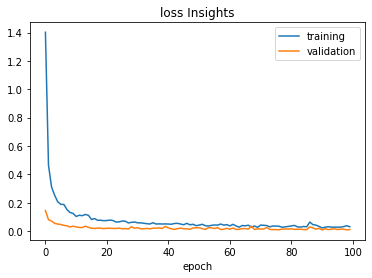

In [33]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss Insights')
plt.xlabel('epoch')





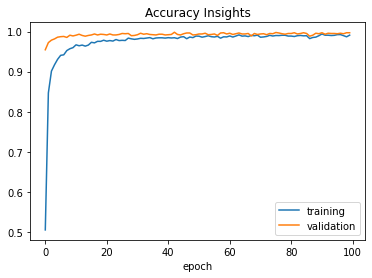

In [34]:
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy Insights')
plt.xlabel('epoch')
plt.show()

In [35]:
score= model.evaluate(x_test,y_test,verbose=0)
print('Test Score= ',score[0])
print('Test Accuracy= ',score[1])

Test Score=  0.013676500879228115
Test Accuracy=  0.9955708384513855


In [36]:
model.save("model.h5")

In [37]:
from keras.models import load_model
model1=load_model('model.h5')

**Testing the Model with Webcam**

In [38]:
width = 640
height = 480
threshold = 0.65 # MINIMUM PROBABILITY TO CLASSIFY
cameraNo = 1
cap = cv2.VideoCapture(cameraNo)
cap.set(3,width)
cap.set(4,height)


def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [39]:
success, imgOriginal = cap.read()

In [40]:
while True:
    success, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img,(32,32))
    img = preProcessing(img)
    cv2.imshow("Processsed Image",img)
    img = img.reshape(1,32,32,1)
    #### PREDICT
    classIndex = int(model.predict_classes(img))
    #print(classIndex)
    predictions = model.predict(img)
    #print(predictions)
    probVal= np.amax(predictions)
    print(classIndex,probVal)

    if probVal> threshold:
        cv2.putText(imgOriginal,str(classIndex) + "   "+str(probVal),
                    (50,50),cv2.FONT_HERSHEY_COMPLEX,
                    1,(0,0,255),1)

    cv2.imshow("Original Image",imgOriginal)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

TypeError: ignored

**Saving the trained model to pickle object**

In [ ]:
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()